In [80]:
import pennylane as qml
from pennylane.optimize import GradientDescentOptimizer, AdamOptimizer
from pennylane import numpy as np

import matplotlib.pyplot as plt

np.random.seed(17)

In [81]:
def circle(samples, center=[0.0, 0.0], radius=np.sqrt(2 / np.pi)):
    """
    Generates a dataset of points with 1/0 labels inside a given radius.

    Args:
        samples (int): number of samples to generate
        center (tuple): center of the circle
        radius (float: radius of the circle

    Returns:
        Xvals (array[tuple]): coordinates of points
        yvals (array[int]): classification labels
    """
    Xvals, yvals = [], []

    for i in range(samples):
        x = 2 * (np.random.rand(2)) - 1
        y = 0
        if np.linalg.norm(x - center) < radius:
            y = 1
        Xvals.append(x)
        yvals.append(y)
    return np.array(Xvals, requires_grad=False), np.array(yvals, requires_grad=False)

In [82]:
def plot_data(X, Y):
    """
    Plots a 2D classification dataset.
    
    Args:
    X (array[tuple]): coordinates of the samples
    Y (array[int]): classification labels
    """    
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    for i in range(len(Y)):
        if Y[i] == 1:
            plt.plot(X[i, 0], X[i, 1], 'ro')
        else:
            plt.plot(X[i, 0], X[i, 1], 'bo')
    
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.title('Dataset')
    plt.show()

In [83]:
def density_matrix(state):
    """Calculates the density matrix representation of a state.

    Args:
        state (array[complex]): array representing a quantum state vector

    Returns:
        dm: (array[complex]): array representing the density matrix
    """
    return state * np.conj(state).T


label_0 = [[1], [0]]
label_1 = [[0], [1]]
state_labels = np.array([label_0, label_1], requires_grad=False)

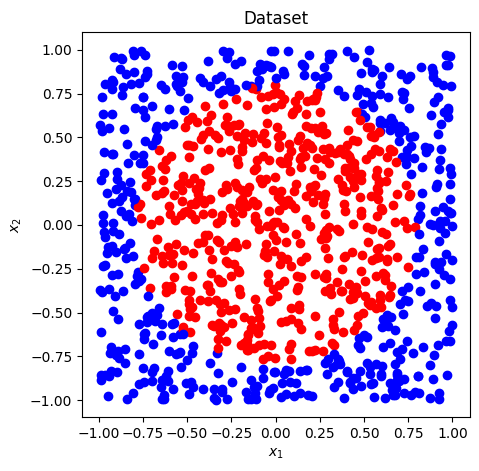

In [84]:
X, Y = circle(1000)
plot_data(X, Y)
plt.show()

In [85]:
dev = qml.device("default.qubit", wires=1)

@qml.qnode(dev)
def qcircuit(params, x=None, y=None):
    """
    A variational quantum circuit representing the data re-uploading classifier.
    """

    for p in params:
        qml.Rot(*x, wires=0)
        qml.Rot(*p, wires=0)

    return qml.expval(qml.Hermitian(y, wires=[0]))

In [86]:
def cost(params, x, y, state_labels=None):
    """Cost function to be minimized.

    Args:
        params (array[float]): array of parameters
        x (array[float]): 2-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): array of state representations for labels

    Returns:
        float: loss value to be minimized
    """
    # Compute prediction for each input in data batch
    loss = 0.0
    dm_labels = np.array([density_matrix(s) for s in state_labels], requires_grad=False)
    for i in range(len(x)):
        f = qcircuit(params, x[i], dm_labels[y[i]])
        loss = loss + (1 - f) ** 2
    return loss / len(x)

In [87]:
def test(params, x, y, state_labels=None):
    """
    Tests on a given set of data.

    Args:
        params (array[float]): array of parameters
        x (array[float]): 2-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): 1-d array of state representations for labels

    Returns:
        predicted (array([int]): predicted labels for test data
        output_states (array[float]): output quantum states from the circuit
    """
    fidelity_values = []
    dm_labels = [density_matrix(s) for s in state_labels]
    predicted = []

    for i in range(len(x)):
        fidel_function = lambda y: qcircuit(params, x[i], y)
        fidelities = [fidel_function(dm) for dm in dm_labels]
        best_fidel = np.argmax(fidelities)

        predicted.append(best_fidel)
        fidelity_values.append(fidelities)

    return np.array(predicted), np.array(fidelity_values)


def accuracy_score(y_true, y_pred):
    """Accuracy score.

    Args:
        y_true (array[float]): 1-d array of targets
        y_predicted (array[float]): 1-d array of predictions
        state_labels (array[float]): 1-d array of state representations for labels

    Returns:
        score (float): the fraction of correctly classified samples
    """
    score = y_true == y_pred
    return score.sum() / len(y_true)


def iterate_minibatches(inputs, targets, batch_size):
    """
    A generator for batches of the input data

    Args:
        inputs (array[float]): input data
        targets (array[float]): targets

    Returns:
        inputs (array[float]): one batch of input data of length `batch_size`
        targets (array[float]): one batch of targets of length `batch_size`
    """
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]


In [88]:
# Generate training and test data
num_training = 200
num_test = 2000

Xdata, y_train = circle(num_training)
X_train = np.hstack((Xdata, np.zeros((Xdata.shape[0], 1), requires_grad=False)))

Xtest, y_test = circle(num_test)
X_test = np.hstack((Xtest, np.zeros((Xtest.shape[0], 1), requires_grad=False)))


# Train using Adam optimizer and evaluate the classifier
num_layers = 3
learning_rate = 0.6
epochs = 10
batch_size = 32

opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)

# initialize random weights
params = np.random.uniform(size=(num_layers, 3), requires_grad=True)

predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
accuracy_train = accuracy_score(y_train, predicted_train)

predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
accuracy_test = accuracy_score(y_test, predicted_test)

# save predictions with random weights for comparison
initial_predictions = predicted_test

loss = cost(params, X_test, y_test, state_labels)

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
        params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, state_labels)

    predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss = cost(params, X_train, y_train, state_labels)

    predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )


Epoch:  0 | Cost: 0.465080 | Train accuracy: 0.400000 | Test Accuracy: 0.365000
Epoch:  1 | Loss: 0.164031 | Train accuracy: 0.820000 | Test accuracy: 0.773000
Epoch:  2 | Loss: 0.153484 | Train accuracy: 0.775000 | Test accuracy: 0.803000
Epoch:  3 | Loss: 0.151961 | Train accuracy: 0.740000 | Test accuracy: 0.767000
Epoch:  4 | Loss: 0.170429 | Train accuracy: 0.735000 | Test accuracy: 0.750500
Epoch:  5 | Loss: 0.140516 | Train accuracy: 0.815000 | Test accuracy: 0.799500
Epoch:  6 | Loss: 0.111518 | Train accuracy: 0.870000 | Test accuracy: 0.887000
Epoch:  7 | Loss: 0.105536 | Train accuracy: 0.870000 | Test accuracy: 0.895000
Epoch:  8 | Loss: 0.103768 | Train accuracy: 0.925000 | Test accuracy: 0.936000
Epoch:  9 | Loss: 0.112975 | Train accuracy: 0.880000 | Test accuracy: 0.884500
Epoch: 10 | Loss: 0.118788 | Train accuracy: 0.860000 | Test accuracy: 0.850500


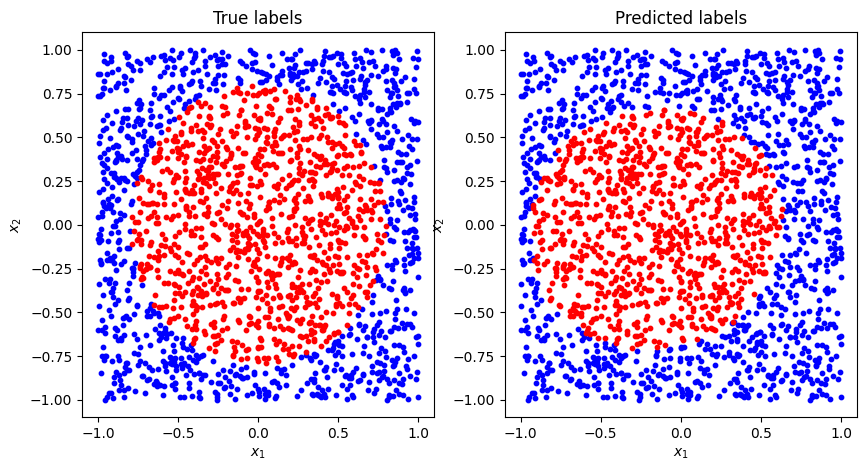

In [89]:
# Plot the predictions

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].scatter(X_test[:, 0][y_test == 0], X_test[:, 1][y_test == 0], color="blue", s=10)
ax[0].scatter(X_test[:, 0][y_test == 1], X_test[:, 1][y_test == 1], color="red", s=10)
ax[0].set_title("True labels")
ax[0].set_xlabel("$x_1$")
ax[0].set_ylabel("$x_2$")

ax[1].scatter(X_test[:, 0][predicted_test == 0], X_test[:, 1][predicted_test == 0], color="blue", s=10)
ax[1].scatter(X_test[:, 0][predicted_test == 1], X_test[:, 1][predicted_test == 1], color="red", s=10)
ax[1].set_title("Predicted labels")
ax[1].set_xlabel("$x_1$")
ax[1].set_ylabel("$x_2$")
plt.show()